In [1]:
import ROOT, os, sys, glob
import numpy as np
import math
from matplotlib import pyplot as plt
from ROOT import kBlack, kBlue, kRed
from array import array

ROOT.EnableImplicitMT(4); 

Welcome to JupyROOT 6.28/00


In [2]:
list(glob.glob("/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/*125X_v0.1.root"))

['/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_HAHM_ZdToMuMu_M10_PU200.125X_v0.1.root',
 '/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_HAHM_ZdToMuMu_M12_PU200.125X_v0.1.root',
 '/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_HAHM_ZdToMuMu_M15_PU200.125X_v0.1.root',
 '/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_HAHM_ZdToMuMu_M25_PU200.125X_v0.1.root',
 '/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_HAHM_ZdToMuMu_M2_PU200.125X_v0.1.root',
 '/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_HAHM_ZdToMuMu_M3p5_PU200.125X_v0.1.root',
 '/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_HAHM_ZdToMuMu_M40_PU200.125X_v0.1.root',
 '/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_HAHM_ZdToMuMu_M4_PU200.125X_v0.1.root',
 '/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_HAHM_ZdToMuMu_M5_PU200.125X_v0.1.root',
 '/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1

In [6]:
def Efficiency_plotter(file_name,m):
    rdf = ROOT.RDataFrame("Events",f"/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/{file_name}")
    def makeDimuonPairs(name, rdf):
        ## define 4-vectors in cartesian coordinates, for easier 
        rdf = rdf.Define(f"{name}Mu_p4", f"ROOT::VecOps::Construct<ROOT::Math::XYZTVector>(ROOT::VecOps::Construct<ROOT::Math::PtEtaPhiMVector>({name}Mu_pt,{name}Mu_eta,{name}Mu_phi,{name}Mu_mass))")
        ## make indices of all the pairs
        rdf = rdf.Define(f"{name}DiMu_indices", f"""
            ROOT::VecOps::RVec<std::pair<int,int>> ret; 
            for (int i = 0, n = n{name}Mu; i < n; ++i) 
                for (int i2 = i+1; i2 < n; ++i2) 
                    ret.emplace_back(i,i2);
            return ret;""")

        #Let us impose a selection criteria here


        ## Make the number of dimuons, for convenience later
        rdf = rdf.Define(f"n{name}DiMu", f"{name}DiMu_indices.size()")
        ## compute the mass, charge
        rdf = rdf.Define(f"{name}DiMu_mass", f"""
            ROOT::RVecF ret; 
            for (const auto & pair : {name}DiMu_indices) 
                ret.emplace_back(({name}Mu_p4[pair.first]+{name}Mu_p4[pair.second]).M());
            return ret;""")


        rdf = rdf.Define(f"{name}DiMu_charge", f"""
            ROOT::RVecI ret; 
            for (const auto & pair : {name}DiMu_indices) 
                ret.emplace_back({name}Mu_charge[pair.first]+{name}Mu_charge[pair.second]);
            return ret;""")



        rdf = rdf.Define(f"{name}DiMu_minIdx", f"""
            ROOT::RVecI ret;
            for (const auto & pair : {name}DiMu_indices) 
                ret.emplace_back(std::min(TkMu_GenMuIdx[pair.first],TkMu_GenMuIdx[pair.second]));
            return ret;""")


        rdf = rdf.Define(f"{name}DiMu_eta", f"""
            ROOT::RVecF ret;
            for (const auto & pair : {name}DiMu_indices) 
                ret.emplace_back(std::max(abs({name}Mu_eta[pair.first]),abs({name}Mu_eta[pair.second])));
            return ret;""")
        
        rdf=rdf.Define(f"{name}DiMu_dz",f"""
            ROOT::RVecF ret;
            for(const auto & pair : {name}DiMu_indices)
                ret.emplace_back(({name}Mu_vz[pair.first]-{name}Mu_vz[pair.second]));
            return ret;""")
        #min pT of thw two
        rdf = rdf.Define(f"{name}Mu_minPT",f"""
            ROOT::RVecF ret;
            for(const auto & pair : {name}DiMu_indices)
                ret.emplace_back(std::min({name}Mu_pt[pair.first],{name}Mu_pt[pair.second]));
            return ret;""") #

        return rdf;
    
    entries_no_pair = rdf.Count().GetValue()

    
####################################################################################################################################################################    
    def makeTk_DiMuonPairs(rdf):
    
        #this is to defne DiMuon pairs for different properties
        rdf = rdf.Define(f"TkDiMu_hwIsoSum", f"""
            ROOT::RVecI ret; 
            for (const auto & pair : TkDiMu_indices) 
                ret.emplace_back(0.03125*(std::max(TkMu_hwIsoSum[pair.first],TkMu_hwIsoSum[pair.second])));
            return ret;""")

        rdf = rdf.Define(f"TkDiMu_hwIsoSumAp", f"""
            ROOT::RVecI ret; 
            for (const auto & pair : TkDiMu_indices) 
                ret.emplace_back(0.03125*(std::max(TkMu_hwIsoSumAp[pair.first],TkMu_hwIsoSumAp[pair.second])));
            return ret;""")

        rdf = rdf.Define(f"TkDiMu_hwQual", f"""
            ROOT::RVecI ret; 
            for (const auto & pair : TkDiMu_indices) 
                ret.emplace_back(std::min(TkMu_hwQual[pair.first],TkMu_hwQual[pair.second]));
            return ret;""")

        return rdf;
    rdf_Tkdimu_one = makeDimuonPairs("Tk",rdf) 
    rdf_Tkdimu = makeTk_DiMuonPairs(rdf_Tkdimu_one)
    
    #h_TkDiMu_mass = rdf_Tkdimu.Histo1D(("","",50,0,50),"TkDiMu_mass")
    
    hNTkPairs = rdf_Tkdimu.Histo1D(("nTkDiMu","N(#mu#mu)_{Tk};Events",12,-2,10), "nTkDiMu")
    h_TkDiMu_mass = rdf_Tkdimu.Histo1D(("TkMass","m(#mu#mu)_{Tk};m (GeV);Pairs",50,0,50), "TkDiMu_mass")
    hTkPairCharge = rdf_Tkdimu.Histo1D(("TkCharge","q(#mu#mu)_{Tk};q(#mu_{1}) + q(#mu_{2});Pairs",8,-4,4), "TkDiMu_charge")
    hTkPair_Dz = rdf_Tkdimu.Histo1D(("TkPair_dz","dz(#mu#mu)_{Tk};z(#mu_{1}) - z(#mu_{2}cm",100,-10,10),"TkDiMu_dz")
    hTkPair_minPt = rdf_Tkdimu.Histo1D(("TkPair_minPt","min p_{T}(#mu#mu)_{Tk};pT GeV",100,0,10),"TkMu_minPT")
    hTkPair_Dz = rdf_Tkdimu.Histo1D(("TkPair_dz","dz(#mu#mu)_{Gen};z(#mu_{1}) - z(#mu_{2})cm",100,-10,10),"TkDiMu_dz")
    hTkPair_minPt = rdf_Tkdimu.Histo1D(("TkPair_minPt","min p_{T}(#mu#mu)_{Gen};pT GeV",100,0,10),"TkMu_minPT")
    hTkPair_hwIsoSum = rdf_Tkdimu.Histo1D(("Tk_IsoSum","Iso Sum(#mu#mu)_{Tk};;Pairs",20,0,20),"TkDiMu_hwIsoSum")
    hTkPair_hwIsoSumAp = rdf_Tkdimu.Histo1D(("Tk_IsoSumAp","Iso Sum Ap(#mu#mu)_{Tk};;Pairs",20,0,20),"TkDiMu_hwIsoSumAp")
    hTkPair_hwQual = rdf_Tkdimu.Histo1D(("Tk_Qual","Qual(#mu#mu)_{Tk};;Pairs",100,0,200),"TkDiMu_hwQual")
 
    entries_Tk_pair = rdf_Tkdimu.Count().GetValue()
    
    c1 = ROOT.TCanvas("c1","c1", 2000, 800)
    c1.Divide(4,2)
    for i, h1 in enumerate([hNTkPairs, h_TkDiMu_mass, hTkPairCharge,hTkPair_Dz,hTkPair_minPt,hTkPair_hwIsoSum, hTkPair_hwIsoSumAp, hTkPair_hwQual]):
        c1.cd(i+1)
        h1.Draw()
    c1.Draw()
    c1.SaveAs(f"{m}_muon_pairs.png")

####################################################################################################################################################################
    
    rdf_genDiMu = makeDimuonPairs("Gen",rdf_Tkdimu)
    
    entries_gen_pair = rdf_genDiMu.Count().GetValue()
    
####################################################################################################################################################################    
    
    def indexSelect(rdf):
        rdf = rdf.Define("TkDiMu_indMatch","(TkDiMu_minIdx!=-1)" )
        rdf = rdf.Define(f"IdxDiMu_indices", f"TkDiMu_indices[TkDiMu_indMatch]")
        #rdf = rdf.Filter(f"Sum(TkDiMu_indMatch)  >= 1")
        rdf = rdf.Define(f"nTkDiMu_Idx",f"IdxDiMu_indices.size()")
        rdf = rdf.Define(f"TkDiMu_IdxMass",f"TkDiMu_mass[TkDiMu_indMatch]")
        rdf = rdf.Define(f"TkDiMu_IdxCharge",f"TkDiMu_charge[TkDiMu_indMatch]")
        rdf = rdf.Define(f"TkDiMu_Idxdz",f"TkDiMu_dz[TkDiMu_indMatch]")
        rdf = rdf.Define(f"TkDiMu_IdxMinPt",f"TkMu_minPT[TkDiMu_indMatch]")
        rdf = rdf.Define(f"TkDiMu_IdxhwIsoSum",f"TkDiMu_hwIsoSum[TkDiMu_indMatch]")
        rdf = rdf.Define(f"TkDiMu_IdxhwIsoSumAp",f"TkDiMu_hwIsoSumAp[TkDiMu_indMatch]")
        rdf = rdf.Define(f"TkDiMu_IdxhwQual",f"TkDiMu_hwQual[TkDiMu_indMatch]")
        rdf = rdf.Define("TkDiMu_IdxEta","TkDiMu_eta[TkDiMu_indMatch]")
        return rdf;

    rdf_idxSel = indexSelect(rdf_genDiMu)
    #hIdxTkPairMass = rdf_idxSel.Histo1D(("Tk_Mass_Idx","Idx m(#mu#mu)_{Tk};m (GeV);Pairs",50,0,50), "TkDiMu_IdxMass")
    
    hNIdxTkPairs = rdf_idxSel.Histo1D(("nTk_DiMu_Idx","Idx N(#mu#mu)_{Tk};Events",10,0,10), "nTkDiMu_Idx")
    hIdxTkPairMass = rdf_idxSel.Histo1D(("Tk_Mass_Idx","Idx m(#mu#mu)_{Tk};m (GeV);Pairs",50,0,50), "TkDiMu_IdxMass")
    hIdxTkPairCharge = rdf_idxSel.Histo1D(("Tk_Charge_Idx","Idx q(#mu#mu)_{Tk};q(#mu_{1}) + q(#mu_{2});Pairs",8,-4,4), "TkDiMu_IdxCharge")
    hIdxTkPairDz = rdf_idxSel.Histo1D((" Tk dz_Idx","Idx dz(#mu#mu)_{TK};z(#mu_{1}) - z(#mu_{2});Pairs",50,0,50), "TkDiMu_Idxdz")
    hIdxTkPairMinPT = rdf_idxSel.Histo1D((" Tk minPt_Idx","Idx min pT(#mu#mu)_{Tk};pT(GeV));Pairs",100,0,10), "TkDiMu_IdxMinPt")
    hIdxTkPair_hwQual = rdf_idxSel.Histo1D((" Tk hwQual_Idx","Idx hwQual(#mu#mu)_{Tk};pT(GeV));Pairs",100,0,200), "TkDiMu_IdxhwQual")
    hIdxTkPair_hwIsoSum = rdf_idxSel.Histo1D((" Tk hwIsoSum_Idx","Idx hwIsoSum(#mu#mu)_{Tk};pT(GeV));Pairs",20,0,20), "TkDiMu_IdxhwIsoSum")
    hIdxTkPair_hwIsoSumAp = rdf_idxSel.Histo1D((" Tk hwIsoSum_Idx Ap","Idx hwIsoSum Ap(#mu#mu)_{Tk};pT(GeV));Pairs",20,0,20), "TkDiMu_IdxhwIsoSumAp")


    entries_idx_pair = rdf_idxSel.Count().GetValue()
    
    c2 = ROOT.TCanvas("c2","c2", 2000, 800)
    c2.Divide(4,2)
    for j, h2 in enumerate([hNIdxTkPairs, hIdxTkPairMass, hIdxTkPairCharge, hIdxTkPairDz, hIdxTkPairMinPT, hIdxTkPair_hwQual, hIdxTkPair_hwIsoSum, hIdxTkPair_hwIsoSumAp]):
        c2.cd(j+1)
        h2.Draw()
    c2.Draw()
    c2.SaveAs(f"{m}_Index_matched_pairs.png")
    
####################################################################################################################################################################
    
    #hIdxTkPairMass = rdf_idxSel.Histo1D(("Tk_Mass_Idx","Idx m(#mu#mu)_{Tk};m (GeV);Pairs",50,0,50), "TkDiMu_IdxMass")

    def select_ind(name, rdf):
    
        #Let us impose a selection criteria here
        #rdf = rdf.Define(f"{name}DiMu_selind",f"{name}DiMu_indices")
        rdf = rdf.Define(f"{name}DiMu_good", f"({name}DiMu_charge<0.1 && {name}DiMu_charge>-0.1) &&({name}DiMu_dz<1 && ({name}DiMu_dz>-1))&&({name}Mu_minPT>2.)&&({name}DiMu_eta <= 2) && (TkDiMu_hwIsoSumAp<=1.5) && (TkDiMu_hwIsoSum<=1.5)")                    
        rdf = rdf.Define(f"Good{name}DiMu_indices", f"{name}DiMu_indices[{name}DiMu_good]")
        rdf = rdf.Filter(f"Sum({name}DiMu_good)  >= 1")
        rdf = rdf.Define(f"n{name}DiMu_sel",f"Good{name}DiMu_indices.size()")
        rdf = rdf.Define(f"{name}DiMu_selMass",f"{name}DiMu_mass[{name}DiMu_good]")
        rdf = rdf.Define(f"{name}DiMu_selCharge",f"{name}DiMu_charge[{name}DiMu_good]")
        rdf = rdf.Define(f"{name}DiMu_seldz",f"{name}DiMu_dz[{name}DiMu_good]")
        rdf = rdf.Define(f"{name}DiMu_selMinPt",f"{name}Mu_minPT[{name}DiMu_good]")
        rdf = rdf.Define(f"{name}DiMu_selEta",f"{name}DiMu_eta[{name}DiMu_good]")

        #rdf = rdf.Define(f"GoodTkDiMu_minIdx_{name}",f"TkDiMu_minIdx[{name}DiMu_good]")
        return rdf;

    rdf_Tk_selFeat = select_ind("Tk",rdf_idxSel)
    #rdf_selFeat = select_ind("Gen", rdf_Tk_selFeat)
    
    h_TkDiMu_selMass = rdf_Tk_selFeat.Histo1D(("","",50,0,50),"TkDiMu_selMass")

    
    def select_idx_tk(rdf):

        #Let us impose a selection criteria here
        #rdf = rdf.Define(f"{name}DiMu_selind",f"{name}DiMu_indices")
        rdf = rdf.Define(f"TkDiMu_Idx_good", f"(TkDiMu_IdxCharge <0.1 && TkDiMu_IdxCharge > -0.1) &&(TkDiMu_Idxdz <1 && (TkDiMu_Idxdz > -1))&&(TkDiMu_IdxMinPt > 2.) && (TkDiMu_IdxhwQual>75) && (TkDiMu_IdxEta <=2)&& (TkDiMu_IdxhwIsoSum<=1.5) && (TkDiMu_IdxhwIsoSumAp<=1.5) ")                    
        rdf = rdf.Define(f"TkDiMu_sel_Idx_indices", f"IdxDiMu_indices[TkDiMu_Idx_good]")
        rdf = rdf.Filter(f"Sum(TkDiMu_Idx_good)  >= 1")
        rdf = rdf.Define(f"nTkDiMu_IdxSel",f"TkDiMu_sel_Idx_indices.size()")
        rdf = rdf.Define(f"TkDiMu_IdxselMass",f"TkDiMu_IdxMass[TkDiMu_Idx_good]")
        rdf = rdf.Define(f"TkDiMu_IdxselCharge",f"TkDiMu_IdxCharge[TkDiMu_Idx_good]")
        rdf = rdf.Define(f"TkDiMu_Idxseldz",f"TkDiMu_Idxdz[TkDiMu_Idx_good]")
        rdf = rdf.Define(f"TkDiMu_IdxselMinPt",f"TkDiMu_IdxMinPt[TkDiMu_Idx_good]")
        rdf = rdf.Define(f"TkDiMu_IdxselhwQual",f"TkDiMu_IdxhwQual[TkDiMu_Idx_good]")
        rdf = rdf.Define(f"TkDiMu_IdxselhwIsoSum",f"TkDiMu_IdxhwIsoSum[TkDiMu_Idx_good]")
        rdf = rdf.Define(f"TkDiMu_IdxselhwIsoSumAp",f"TkDiMu_IdxhwIsoSumAp[TkDiMu_Idx_good]")
        rdf = rdf.Define(f"GoodTkDiMu_minIdx",f"TkDiMu_minIdx[TkDiMu_Idx_good]")
        rdf = rdf.Define(f"TkDiMu_IdxselEta",f"TkDiMu_IdxEta[TkDiMu_Idx_good]")

        return rdf;
    
    rdf_Tk_IdxselFeat = select_idx_tk(rdf_Tk_selFeat)

    hNGoodIdxTkPairs = rdf_Tk_IdxselFeat.Histo1D(("good nTk_DiMu_sel","Good N(#mu#mu)_{Tk};Events",10,0,10), "nTkDiMu_IdxSel")
    hGoodIdxTkPairMass = rdf_Tk_IdxselFeat.Histo1D(("Good Tk_Mass","Good m(#mu#mu)_{Tk};m (GeV);Pairs",50,0,50), "TkDiMu_IdxselMass")
    hGoodIdxTkPairCharge = rdf_Tk_IdxselFeat.Histo1D(("Good Tk_Charge","Good q(#mu#mu)_{Tk};q(#mu_{1}) + q(#mu_{2});Pairs",8,-4,4), "TkDiMu_IdxselCharge")
    hGoodIdxTkPairDz = rdf_Tk_IdxselFeat.Histo1D(("Good Tk dz","Good dz(#mu#mu)_{TK};z(#mu_{1}) - z(#mu_{2});Pairs",100,-20,20), "TkDiMu_Idxseldz")
    hGoodIdxTkPairMinPT = rdf_Tk_IdxselFeat.Histo1D(("Good Tk minPt","Good min pT(#mu#mu)_{Tk};pT(GeV));Pairs",100,0,10), "TkDiMu_IdxselMinPt")
    hGoodIdxTkPairhwQual = rdf_Tk_IdxselFeat.Histo1D(("Good Tk hw Qual","Good hw Qual(#mu#mu)_{Tk};);Pairs",100,0,200), "TkDiMu_IdxselhwQual")
    hGoodIdxTkPairhwIsoSum = rdf_Tk_IdxselFeat.Histo1D(("Good Tk hw Iso Sum","Good hw Iso Sum(#mu#mu)_{Tk};);Pairs",20,0,30), "TkDiMu_IdxselhwIsoSum")
    hGoodIdxTkPairhwIsoSumAp = rdf_Tk_IdxselFeat.Histo1D(("Good Tk hw Iso Sum Ap","Good hw Iso Sum Ap(#mu#mu)_{Tk};);Pairs",20,0,20), "TkDiMu_IdxselhwIsoSumAp")
       
    entries_selIdx_pair = rdf_Tk_IdxselFeat.Count().GetValue()
    
    c3 = ROOT.TCanvas("c3","c3", 2000, 800)
    c3.Divide(4,2)
    for k, h3 in enumerate([hNGoodIdxTkPairs, hGoodIdxTkPairMass, hGoodIdxTkPairCharge, hGoodIdxTkPairDz, hGoodIdxTkPairMinPT, hGoodIdxTkPairhwQual, hGoodIdxTkPairhwIsoSum, hGoodIdxTkPairhwIsoSumAp]):
        c3.cd(k+1)
        h3.Draw()
    c3.Draw()
    c3.SaveAs(f"{m}_selection_and_index.png")

    
####################################################################################################################################################################    
    #hGoodIdxTkPairMass = rdf_Tk_IdxselFeat.Histo1D(("Good Tk_Mass","Good m(#mu#mu)_{Tk};m (GeV);Pairs",50,0,50), "TkDiMu_IdxselMass")
    
    h1 = hGoodIdxTkPairMass.GetPtr()
    h1.SetLineColor(kBlue+1)
    h1.SetLineWidth(2)
    h1.SetMaximum(4000)
    h2 = hIdxTkPairMass.GetPtr()
    h2.SetLineColor(kRed)
    h2.SetLineWidth(2)
    h2.SetMaximum(4000)
    
    def createRatio(h1, h2):
        h3 = h1.Clone("h3")
        h3.SetLineColor(kBlack)
        h3.SetMarkerStyle(21)
        h3.SetTitle("")
        h3.SetMinimum(0)
        h3.SetMaximum(1.2)
        # Set up plot for markers and errors
        h3.Sumw2() #what is this used for (removal of zeros is the rough idea I have)
        h3.SetStats(0)
        h3.Divide(h2)

    #     # Adjust y-axis settings
        y = h3.GetYaxis()
        y.SetTitle("ratio h1/h2 ")
        y.SetNdivisions(505)
        y.SetTitleSize(20)
        y.SetTitleFont(43)
        y.SetTitleOffset(1.55)
        y.SetLabelFont(43)
        y.SetLabelSize(15)

    #     # Adjust x-axis settings
        x = h3.GetXaxis()
        x.SetTitleSize(20)
        x.SetTitleFont(43)
        x.SetTitleOffset(4.0)
        x.SetLabelFont(43)
        x.SetLabelSize(15)

        return h3;
    
    
    h3 = createRatio(h1, h2)
    
    e1 = entries_selIdx_pair/entries_no_pair
    e2 = entries_selIdx_pair/entries_idx_pair
    
    
    return dict(h1=h1,h2=h2,h3=h3,hNTkPairs=hNTkPairs, h_TkDiMu_mass=h_TkDiMu_mass, hTkPairCharge=hTkPairCharge, hTkPair_Dz=hTkPair_Dz,hTkPair_minPt=hTkPair_minPt,hTkPair_hwIsoSum=hTkPair_hwIsoSum, hTkPair_hwIsoSumAp=hTkPair_hwIsoSumAp, hTkPair_hwQual=hTkPair_hwQual, hNIdxTkPairs = hNIdxTkPairs, hIdxTkPairMass = hIdxTkPairMass, hIdxTkPairCharge =  hIdxTkPairCharge, hIdxTkPairDz = hIdxTkPairDz, hIdxTkPairMinPT = hIdxTkPairMinPT, hIdxTkPair_hwQual = hIdxTkPair_hwQual, hIdxTkPair_hwIsoSum = hIdxTkPair_hwIsoSum, hIdxTkPair_hwIsoSumAp = hIdxTkPair_hwIsoSumAp ,  hNGoodIdxTkPairs = hNGoodIdxTkPairs, hGoodIdxTkPairMass = hGoodIdxTkPairMass, hGoodIdxTkPairCharge = hGoodIdxTkPairCharge, hGoodIdxTkPairDz = hGoodIdxTkPairDz, hGoodIdxTkPairMinPT = hGoodIdxTkPairMinPT, hGoodIdxTkPairhwQual = hGoodIdxTkPairhwQual, hGoodIdxTkPairhwIsoSum = hGoodIdxTkPairhwIsoSum, hGoodIdxTkPairhwIsoSumAp = hGoodIdxTkPairhwIsoSumAp, c1 =c1, c2=c2, c3 =c3);






Error in <TNetXNGFile::Open>: [ERROR] Server responded with an error: [3010] Unable to give access - user access restricted - unauthorized identity used ; Permission denied

Error in <TNetXNGFile::Open>: [ERROR] Server responded with an error: [3010] Unable to give access - user access restricted - unauthorized identity used ; Permission denied

Error in <TNetXNGFile::Open>: [ERROR] Server responded with an error: [3010] Unable to give access - user access restricted - unauthorized identity used ; Permission denied

Error in <TNetXNGFile::Open>: [ERROR] Server responded with an error: [3010] Unable to give access - user access restricted - unauthorized identity used ; Permission denied

Error in <TNetXNGFile::Open>: [ERROR] Server responded with an error: [3010] Unable to give access - user access restricted - unauthorized identity used ; Permission denied

Error in <TNetXNGFile::Open>: [ERROR] Server responded with an error: [3010] Unable to give access - user access restricted - unau

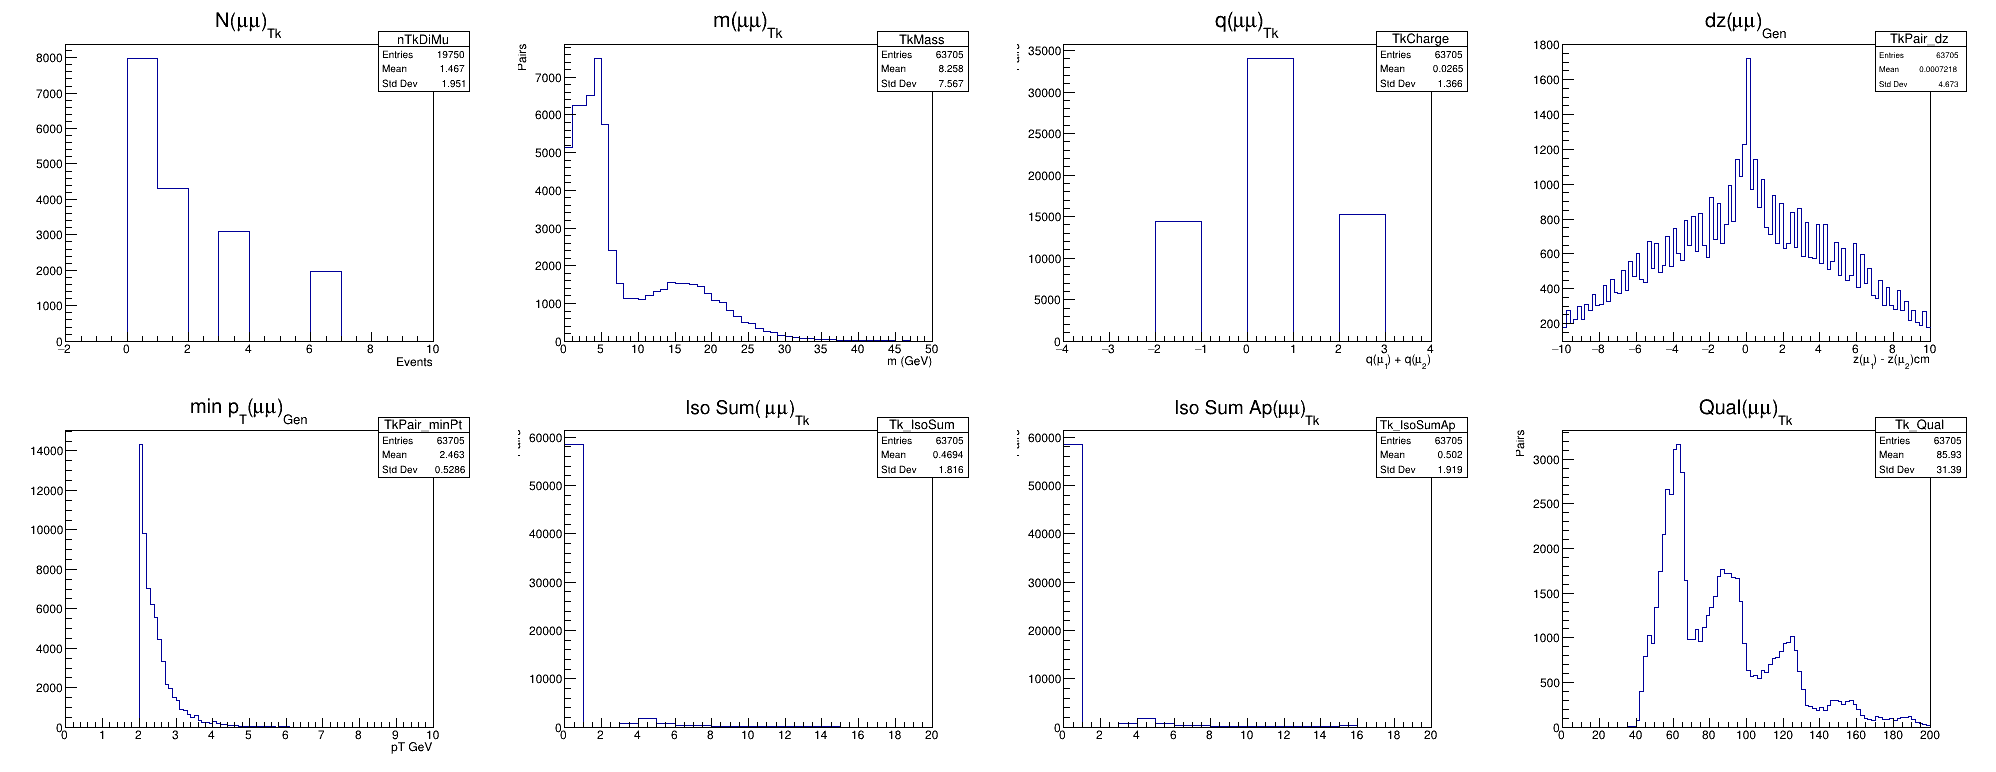

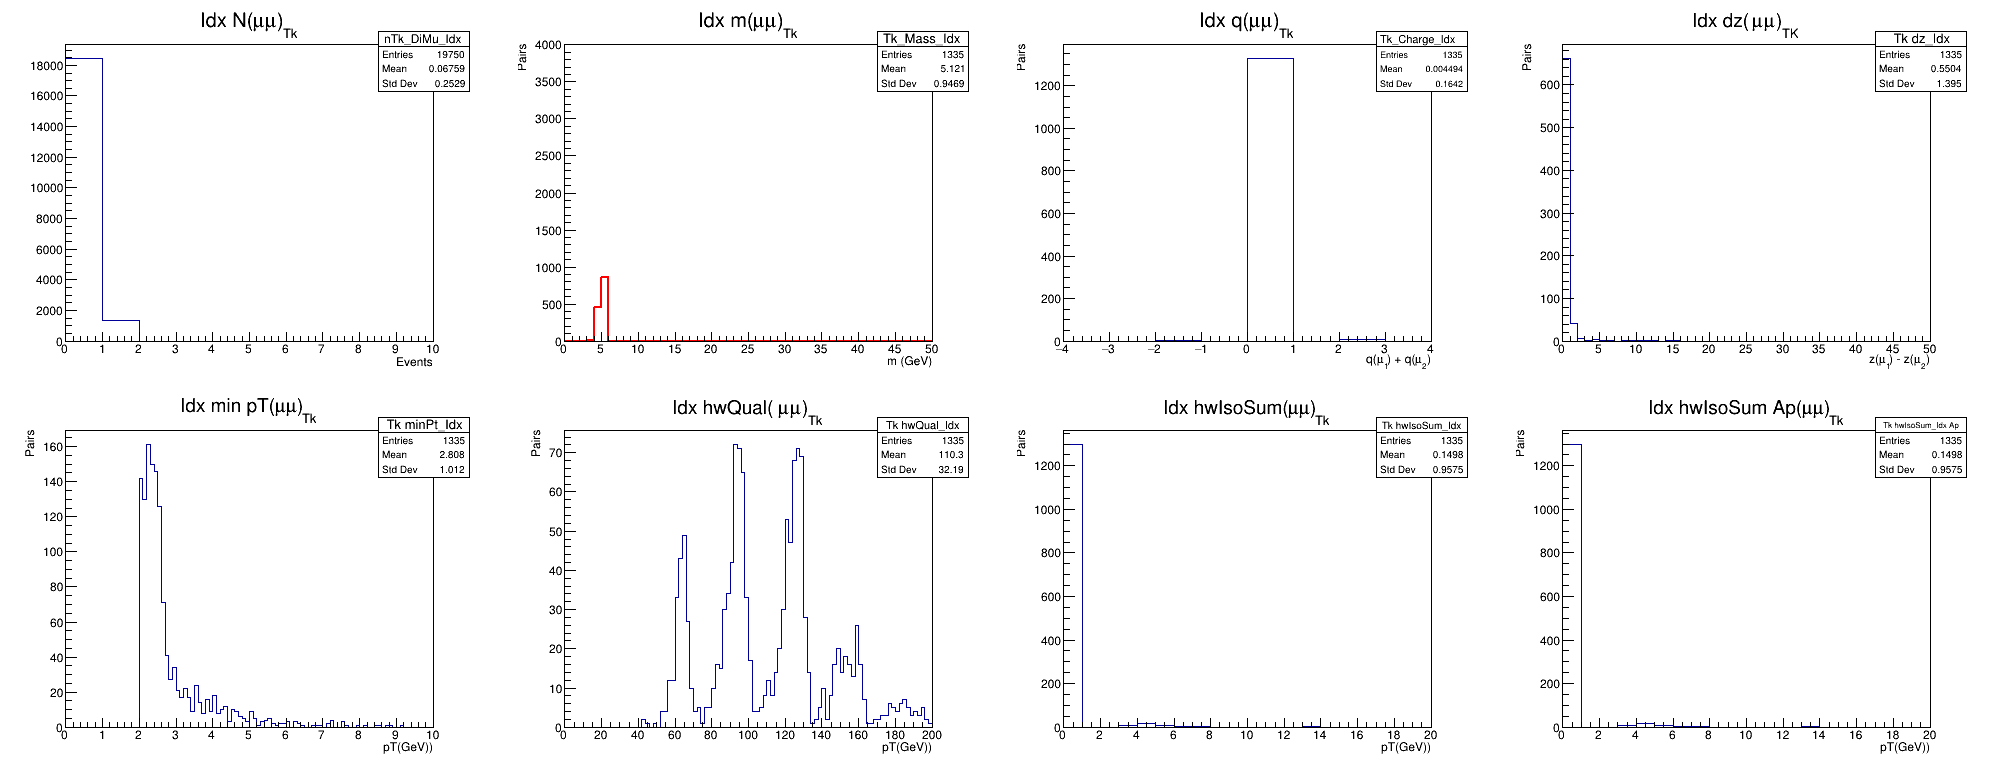

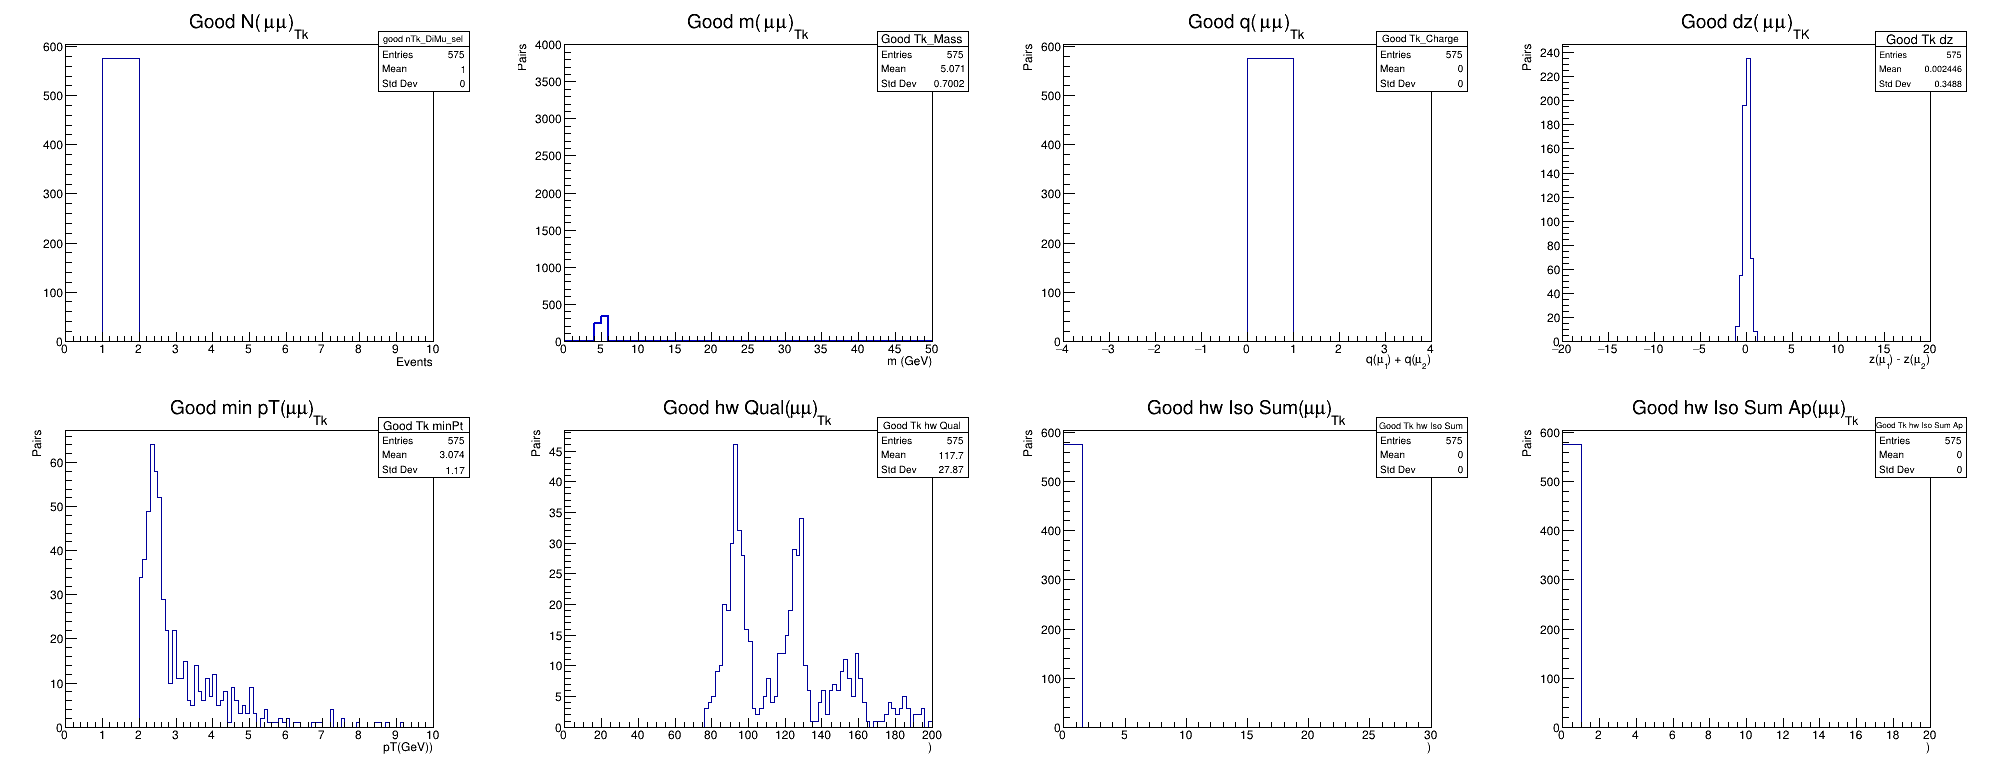

In [8]:
data = Efficiency_plotter("l1MuNano_HAHM_ZdToMuMu_M5_PU200.125X_v0.1.root",5)

In [9]:
# c1 = data['c1']
# c1.Draw()

AttributeError: 'CPyCppyy_NoneType' object has no attribute 'Draw'